In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# downloading the NLTK Stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "/content/drive/MyDrive/model1.h5"
WORD2VEC_MODEL = "/content/drive/MyDrive/model1.w2v"
TOKENIZER_MODEL = "/content/drive/MyDrive/tokenizer1.pkl"
ENCODER_MODEL = "/content/drive/MyDrive/encoder.pkl1"

dataset_path = "/content/drive/MyDrive/training.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/drive/MyDrive/training.csv


In [ ]:
print(f'DataFrame Size: {len(df)}')
df.head(10)

DataFrame Size: 1600000


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


Text(0.5, 1.0, 'Dataset labels distribuition')

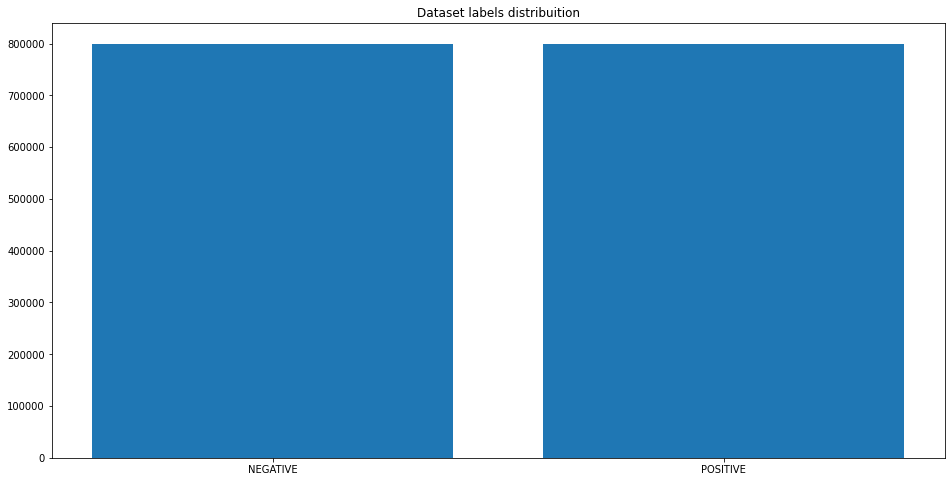

In [ ]:
# mapping target label to string

decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

df.target = df.target.apply(lambda x: decode_sentiment(x))

target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
# pre-processing the dataset

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

In [ ]:
# splitting the training and testing datasets

df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [ ]:
# implementing Word2Vec Model on the dataset

documents = [_text.split() for _text in df_train.text] 
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

w2v_model.build_vocab(documents)

In [ ]:
# checking the most similar words given another word

w2v_model.most_similar("love")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('govt', 0.23479780554771423),
 ('widow', 0.22887052595615387),
 ('overtaking', 0.21987846493721008),
 ('contributions', 0.21801286935806274),
 ('folk', 0.21447420120239258),
 ('cuma', 0.20806574821472168),
 ('logical', 0.20295840501785278),
 ('elses', 0.20050087571144104),
 ('lighter', 0.2004905343055725),
 ('mowed', 0.19738198816776276)]

In [ ]:
# tokenizing the text of the dataset

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419


In [ ]:
# padding the data

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [ ]:
# encoding the labels

labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
print(f'Unique Labels of the dataset: {labels}')

encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# displaying the shapes of the splitted dataset
print(f'Shape of X_train: {x_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Unique Labels of the dataset: ['POSITIVE', 'NEGATIVE', 'NEUTRAL']
Shape of X_train: (1280000, 300)
Shape of y_train: (1280000, 1)
Shape of X_test: (320000, 300)
Shape of y_test: (320000, 1)


In [ ]:
# building the Embedding Layer for embedding the data

embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(f'Shape of Embedding Matrix: {embedding_matrix.shape}')
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

Shape of Embedding Matrix: (290419, 300)


In [ ]:
# building the LSTM Model

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# generating the summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          87125700  
                                                                 
 dropout_2 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [ ]:
# compiling the model

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# setting the Callbacks

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

# training the model

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.5799

1125/1125 [==============================] - 662s 587ms/step - loss: 0.6752 - accuracy: 0.5799 - val_loss: 0.6488 - val_accuracy: 0.6371 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.5982

1125/1125 [==============================] - 656s 583ms/step - loss: 0.6672 - accuracy: 0.5982 - val_loss: 0.6422 - val_accuracy: 0.6402 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.6101

1125/1125 [==============================] - 655s 582ms/step - loss: 0.6550 - accuracy: 0.6101 - val_loss: 0.6385 - val_accuracy: 0.6441 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - ETA: 0s - loss: 0.6537 - accuracy: 0.6116

1125/1125 [==============================] - 645s 573ms/step - loss: 0.6537 - accuracy: 0.6116 - val_loss: 0.6369 - val_accuracy: 0.6451 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.6130

1125/1125 [==============================] - 643s 572ms/step - loss: 0.6526 - accuracy: 0.6130 - val_loss: 0.6363 - val_accuracy: 0.6440 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - ETA: 0s - loss: 0.6522 - accuracy: 0.6130

1125/1125 [==============================] - 643s 571ms/step - loss: 0.6522 - accuracy: 0.6130 - val_loss: 0.6337 - val_accuracy: 0.6475 - lr: 0.0010
Epoch 7/8
1125/1125 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.6149

1125/1125 [==============================] - 639s 568ms/step - loss: 0.6511 - accuracy: 0.6149 - val_loss: 0.6321 - val_accuracy: 0.6486 - lr: 0.0010
Epoch 8/8
1125/1125 [==============================] - ETA: 0s - loss: 0.8683 - accuracy: 0.5970

1125/1125 [==============================] - 647s 575ms/step - loss: 0.8683 - accuracy: 0.5970 - val_loss: 0.6899 - val_accuracy: 0.5204 - lr: 0.0010


In [ ]:
# saving the models

model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

313/313 [==============================] - 35s 112ms/step - loss: 0.6897 - accuracy: 0.5210

ACCURACY: 0.5210250020027161
LOSS: 0.6897361278533936


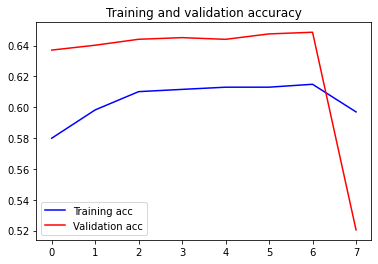

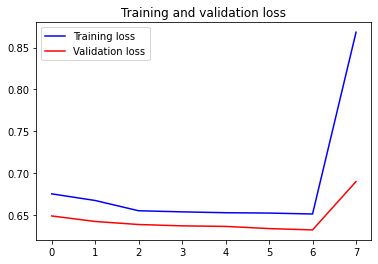

In [ ]:
# evaluating the models

score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
# prediction phase

# function to decode the sentiment
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

# function to predict the sentiment
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
# testing some manual sentences

predict("i don't know what i'm doing")

{'label': 'NEUTRAL',
 'score': 0.5292870998382568,
 'elapsed_time': 0.12513971328735352}

In [ ]:
# plotting the CONFUSION MATRIX

y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

40/40 [==============================] - 23s 559ms/step


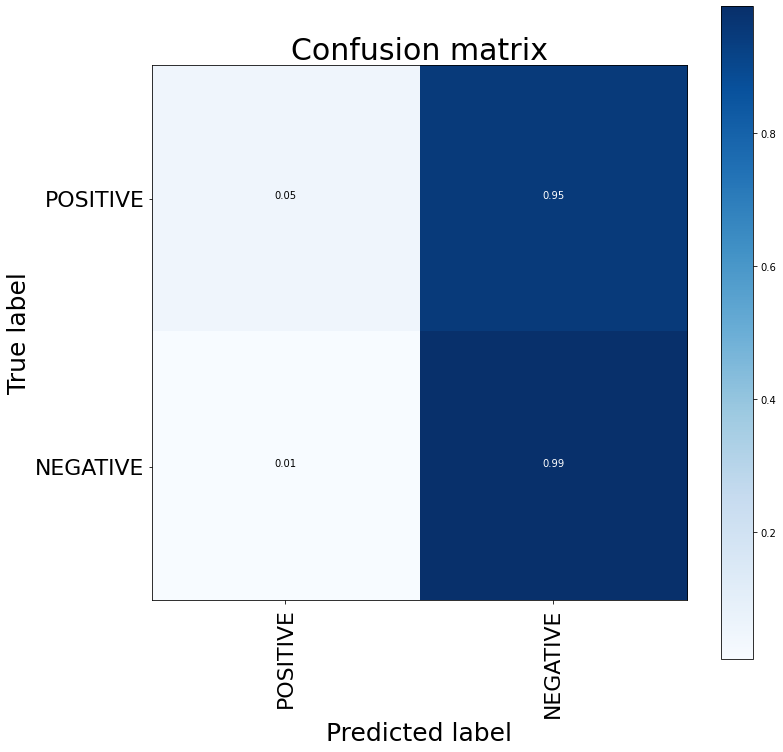

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
# displaying the classification report

print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.83      0.05      0.09    159494
    POSITIVE       0.51      0.99      0.67    160506

    accuracy                           0.52    320000
   macro avg       0.67      0.52      0.38    320000
weighted avg       0.67      0.52      0.38    320000



In [ ]:
# displaying accuracy score

accuracy_score(y_test_1d, y_pred_1d)

0.521025